In [1]:
import pandas as pd 
import jieba
import re 
import jieba
import string 
from sklearn.metrics import precision_recall_fscore_support
import torch 
from torch import nn 
import torch.nn.functional as F 
import torch.optim as optim
import torch.utils.data as Data
from torchtext import data
from torchtext.vocab import Vectors
from torchtext.legacy.data import Field,TabularDataset,Iterator,BucketIterator 

In [2]:
#构建数据集
mytokenize = lambda x: x.split()
TEXT = Field(sequential=True,tokenize=mytokenize,include_lengths=True,use_vocab=True,batch_first=True)
LABEL=Field(sequential=False,use_vocab=False,pad_token=None,unk_token=None) 
text_data_fields = [("label",LABEL),("title",TEXT)]   
traindata,validdata,testdata=TabularDataset.splits(path=r"C:\Users\xumin\大作业",format="csv",train="train2.csv",fields=text_data_fields,
                                                  validation="val2.csv",test="test2.csv",skip_header=True)     

In [3]:
BATCH_SIZE = 64 
train_iter = BucketIterator(traindata,batch_size = BATCH_SIZE)
val_iter = BucketIterator(validdata,batch_size = BATCH_SIZE) 
test_iter = BucketIterator(testdata,batch_size = BATCH_SIZE)    

In [4]:
class LSTMNet(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,layer_dim,output_dim):
        super(LSTMNet,self).__init__()
        self.hidden_dim = hidden_dim #LSTM神经元个数
        self.layer_dim = layer_dim  #LSTM层数
        #对文本进行词向量处理  
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        #LSTM+全连接层 
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,layer_dim,batch_first=True) 
        self.fc1 = nn.Linear(hidden_dim,output_dim) 
    def forward(self,x):   
        embeds = self.embedding(x) 
        r_out,(h_n,h_c) = self.lstm(embeds, None)
        out = self.fc1(r_out[:,-1,:])
        return out  

In [5]:
TEXT.build_vocab(traindata,max_size=20000,vectors=None)
LABEL.build_vocab(traindata) 
vocab_size = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 100      
layer_dim = 1   
output_dim = 2  
lstmmodel = LSTMNet(vocab_size,embedding_dim,hidden_dim,layer_dim,output_dim)
lstmmodel 

LSTMNet(
  (embedding): Embedding(15415, 100)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=2, bias=True)
)

In [6]:
import time
def train_model2(model,traindataloader,valdataloader,criterion,optimizer,num_epochs ):
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time ()
    for epoch in range(num_epochs): 
        print('-'*10) 
        print('Epoch{}/{}'.format(epoch,num_epochs-1))  
        ##每个epoch有两个阶段
        train_loss =0.0
        train_corrects = 0  
        train_num = 0
        val_loss =0.0 
        val_corrects = 0
        val_num = 0
        model.train()
        for step,batch in enumerate(traindataloader):  
            textdata,target = batch.title[0],batch.label.view(-1)    
            out = model(textdata)
            pre_lab = torch.argmax(out,1)
            loss = criterion(out,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            train_loss+=loss.item()*len(target) 
            train_corrects += torch.sum(pre_lab ==target.data)
            train_num += len(target)
        ##计算一个epoch在训练集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        print('{}Train Loss:{:.4f}  Train Acc:{:.4f}'.format(
            epoch, train_loss_all[-1],train_acc_all[-1] ))
        #评估阶段 
        model.eval()
        for step,batch in enumerate(valdataloader): 
            textdata,target = batch.title[0],batch.label.view(-1)   
            out = model(textdata)
            pre_lab = torch.argmax(out,1)
            loss = criterion(out,target)     
            val_loss += loss.item()*len(target)   
            val_corrects += torch.sum(pre_lab ==target.data)
            val_num += len(target)  
            
        ##计算一个epoch在验证集上的损失和精度
        val_loss_all.append(val_loss / val_num)  
        val_acc_all.append(val_corrects.double().item()/val_num)
        print('{}Val Loss:{:.4f}  Val Acc:{:.4f}'.format(
            epoch, val_loss_all[-1],val_acc_all[-1]))  
    train_process = pd.DataFrame(
            data={"epoch":range(num_epochs),
                  "train_loss_all":train_loss_all,
                  "train_acc_all":train_acc_all,  
                  "val_loss_all":val_loss_all,
                  "val_acc_all":val_acc_all   })
    return model,train_process    

In [7]:
optimizer = torch.optim.Adam(lstmmodel.parameters(),lr=0.0003) 
loss_func = nn.CrossEntropyLoss()    
lstmmodel,train_process = train_model2(lstmmodel,train_iter,val_iter,loss_func,optimizer,num_epochs=20)        

----------
Epoch0/19
0Train Loss:0.5802  Train Acc:0.7346
0Val Loss:0.5618  Val Acc:0.7527
----------
Epoch1/19
1Train Loss:0.5762  Train Acc:0.7387
1Val Loss:0.5604  Val Acc:0.7546
----------
Epoch2/19
2Train Loss:0.5739  Train Acc:0.7396
2Val Loss:0.5628  Val Acc:0.7539
----------
Epoch3/19
3Train Loss:0.5127  Train Acc:0.7719
3Val Loss:0.3720  Val Acc:0.8644
----------
Epoch4/19
4Train Loss:0.3047  Train Acc:0.8919
4Val Loss:0.2683  Val Acc:0.9117
----------
Epoch5/19
5Train Loss:0.2216  Train Acc:0.9272
5Val Loss:0.2239  Val Acc:0.9243
----------
Epoch6/19
6Train Loss:0.1666  Train Acc:0.9499
6Val Loss:0.2088  Val Acc:0.9344
----------
Epoch7/19
7Train Loss:0.1422  Train Acc:0.9598
7Val Loss:0.1840  Val Acc:0.9407
----------
Epoch8/19
8Train Loss:0.1211  Train Acc:0.9664
8Val Loss:0.1930  Val Acc:0.9451
----------
Epoch9/19
9Train Loss:0.1057  Train Acc:0.9706
9Val Loss:0.1652  Val Acc:0.9521
----------
Epoch10/19
10Train Loss:0.0904  Train Acc:0.9768
10Val Loss:0.1566  Val Acc:0.9

In [8]:
from sklearn.metrics import accuracy_score
lstmmodel.eval()
test_y_all = torch.LongTensor()
pre_lab_all = torch.LongTensor()
for step,batch in enumerate(test_iter):
    textdata,target = batch.title[0],batch.label.view(-1)    
    out = lstmmodel(textdata)
    pre_lab = torch.argmax(out,1)   
    test_y_all=torch.cat((test_y_all,target))  
    pre_lab_all=torch.cat((pre_lab_all,pre_lab))    
acc = accuracy_score(test_y_all,pre_lab_all) 
print("在测试集上的预测精度为：",acc)    
precision_recall_fscore_support(test_y_all,pre_lab_all,average='macro')     

在测试集上的预测精度为： 0.903559806725175


(0.8303259137365389, 0.7477799965992963, 0.7800669607416153, None)

In [9]:
from sklearn.metrics import roc_auc_score 
print ("AUC is",roc_auc_score(test_y_all, pre_lab_all)) 

AUC is 0.7477799965992963


In [10]:
precision_recall_fscore_support(test_y_all,pre_lab_all,average='weighted')   

(0.8958538591273183, 0.903559806725175, 0.8967018015922545, None)

In [11]:
from sklearn.metrics import roc_auc_score 
print ("AUC is",roc_auc_score(test_y_all, pre_lab_all)) 

AUC is 0.7477799965992963


In [12]:
torch.save(lstmmodel,r"C:\Users\xumin\深度学习作业/lstmmodel.pkl") 
train_process.to_csv(r"C:\Users\xumin\深度学习作业/lstmmodel_process1.csv",index = False)   

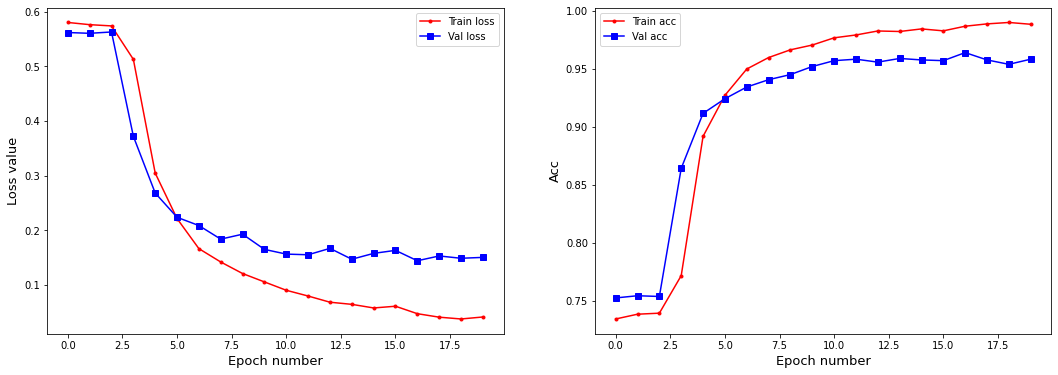

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns   
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/华文细黑.ttf") 
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,"r.-",label = "Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,"bs-",label = "Val loss")  
plt.legend()
plt.xlabel("Epoch number",size = 13)
plt.ylabel("Loss value",size = 13)
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,"r.-",label = "Train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,"bs-",label = "Val acc") 
plt.xlabel("Epoch number",size = 13)  
plt.ylabel("Acc",size = 13)
plt.legend()  
plt.show()  